In [1]:
import numpy as np
import csv,json
import pandas as pd
# mute the warnings
import warnings
warnings.filterwarnings("ignore")
import nltk.data
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from nltk import tokenize

# (1) Data Preparation

In [2]:
# See the script(Data_collect_preparation)
df_stocks = pd.read_pickle('pickled_twenty_year_filtered_lead_para.pkl')


################################################################################################
## Preparing russessl data
# Reading russel index prices csv file
with open('Russell_2000.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    # Converting the csv file reader to a lists 
    data_list = list(spamreader)

# Separating header from the data
header = data_list[0] 
data_list = data_list[1:] 

data_list = np.asarray(data_list)

# Selecting date and close value for each day
selected_data = data_list[:, [0, 4, 5]]



df = pd.DataFrame(data=selected_data[0:,1:],
             index=selected_data[0:,0],
                                columns=['close', 'adj close'],
                                        dtype='float64')

# Reference for pandas interpolation http://pandas.pydata.org/pandas-docs/stable/missing_data.html
# Adding missing dates to the dataframe
df1 = df
idx = pd.date_range('01-03-2000', '12-30-2019')
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN)

interpolated_df = df1.interpolate()
interpolated_df.count() 

# Removing extra date rows added in data for calculating interpolation
# interpolated_df = interpolated_df[3:]

interpolated_df.head()
df_stocks['prices'] = interpolated_df['close'].apply(np.int64)
df_stocks.head()

,close,adj close,articles,prices
2000-01-03,11357.509766,11357.509766,. Looking Back to Move Forward. A Touch of Spr...,496
2000-01-04,10997.929688,10997.929688,. No Bones About It. Carroll and Rhodes Are Ou...,478
2000-01-05,11122.650391,11122.650391,". Climate Control. With Mild Winter, Snow Busi...",478
2000-01-06,11253.259766,11253.259766,". Calling All Units. Larry Bearnarth, 58, the ...",475
2000-01-07,11522.559570,11522.559570,. Nature in a Flick of the Eye. Defense Chief ...,488


# (2) Data Statistics

In [3]:
# See script(data_stats) for 

# (3) BaseLine 1: Vader

In [4]:
# See the other script For Baseline 1

# (4) BaseLine 2: Train Multiple-Linear Regression model on the words sentiment

In [5]:
# Clean the Text file
s = stopwords.words("english")
def clean_review(review, remove_stopwords = False):
    """
     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    ### Add your code here.
    #Removing HTML Markup: The BeautifulSoup Package, a stable way to remove HTML tags
    X1 = BeautifulSoup(review).get_text()
    X2 = re.sub("[^a-zA-Z]"," ",X1) # Substitue all non-letters with empty.
    X3 = X2.lower().split() # transform to lower case and then split into list
    cleaned_review = X3
    if remove_stopwords:
        global s
        X4 = [w for w in X3 if not w in s]
        cleaned_review = X4
    #####################
    
    return cleaned_review

def Get_Data(Price_col_name,News_col_name,Data,n_days):
    
    '''
    Use the input Data to get the n_days Log_return
    The output data is only with two columns log_return and news
    
    input: n_days(list) with long term, mid term and short term return days
    '''
    L = []
    for j in n_days:
        Data[str(j)+'days'+'_LogReturn'] = np.log(Data[Price_col_name]).shift(-j)-np.log(Data[Price_col_name])
        L.append(str(j)+'days'+'_LogReturn')

    Data = Data.dropna()
    
    Data['News'] = ''
    for i in range(len(Data)):
        Data['News'][i] = clean_review(Data[News_col_name][i],True)
    
    L.append('News')
    Data = Data[L]
    return Data

In [6]:
# Get the cleaned data
Data = Get_Data('prices','articles',df_stocks,[3,10,22])

In [7]:
# Get the Vocaublary Statistics
vocabulary = set()
for i in range(0 ,len(Data)):
    line = Data['News'].values[i]
#     print(line)
    words = line
#     print(words)
    for word in words:
        if word not in vocabulary:
            vocabulary.add(word)
print (len(vocabulary))

164778


In [10]:
# Use 1000 vocabularies as Words vector
D = dict()
V = list(vocabulary)
for i in V:
    D[i] = 0
for i in range(len(Data)):
    for j in Data['News'][i]:
        D[j] = D[j]+1

sorted_D = sorted(D.items(), key=lambda kv: kv[1])
sorted_D = sorted_D[163778:]
V_y = [i[0] for i in sorted_D]
len(V_y)

1000

In [11]:
Data.head()

,3days_LogReturn,10days_LogReturn,22days_LogReturn,News
2000-01-03,-0.043261,0.010030,0.049174,"[looking, back, move, forward, touch, spring, ..."
2000-01-04,0.020705,0.058900,0.086139,"[bones, carroll, rhodes, flutie, paid, notice,..."
2000-01-05,0.028868,0.062837,0.078432,"[climate, control, mild, winter, snow, busines..."
2000-01-06,0.045275,0.071096,0.059261,"[calling, units, larry, bearnarth, best, relie..."
2000-01-07,0.026291,0.046054,0.026291,"[nature, flick, eye, defense, chief, pledges, ..."


In [12]:
# Construct the word vector for everyday
# It takes almost an hour on my computer
n = len(V_y)
Data['Bag_of_Words'] = ''
for i in range(len(Data)):
    temp = np.zeros(n)
    if i%1000==0:
        display(i)
    for j in Data['News'][i]:
        for k in range(len(V_y)):
            if V_y[k]==j:
                temp[k] = temp[k]+1
    Data['Bag_of_Words'][i] = list(temp)

0

1000

2000

3000

4000

5000

6000

7000

In [13]:
# Drop those days with too little valid X variable
I = []
for i in range(len(Data)):
    if sum(Data['Bag_of_Words'][i])<50:
        
        I.append(Data.index[i])
Data.drop(I,inplace=True)

In [98]:
# 70% for train 30% for test
Train = Data.iloc[:5000,:]
Test = Data.iloc[5000:,:]
X_train = []
for i in range(len(Train)):
    X_train.append(Train['Bag_of_Words'][i])
X_train = np.array(X_train)
X_test = []
for i in range(len(Test)):
    X_test.append(Test['Bag_of_Words'][i])
X_test = np.array(X_test)
X_test

array([[ 0.,  0.,  0., ..., 21., 22., 22.],
       [ 0.,  0.,  0., ...,  7.,  8.,  8.],
       [ 1.,  0.,  1., ..., 48., 55., 55.],
       ...,
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [99]:
Modi = False
from sklearn.decomposition import PCA 
if Modi == True:  
    pca = PCA(n_components = 40)

    X_train = pca.fit_transform(X_train) 
    X_test = pca.transform(X_test) 
    X_test
    
    explained_variance = pca.explained_variance_ratio_
    print(explained_variance)

In [100]:
y1_train = np.array(Train['3days_LogReturn']).reshape(-1,1)
y2_train = np.array(Train['10days_LogReturn']).reshape(-1,1)
y3_train = np.array(Train['22days_LogReturn']).reshape(-1,1)
y1_test = np.array(Test['3days_LogReturn'])
y2_test = np.array(Test['10days_LogReturn'])
y3_test = np.array(Test['22days_LogReturn'])
from sklearn.linear_model import ElasticNet
enet1 = ElasticNet(alpha=0.00028)
enet2 = ElasticNet(alpha=0.00028)
enet3 = ElasticNet(alpha=0.00028)

Model_ElasticNet_Short_Term = enet1.fit(X_train,y1_train)
Model_ElasticNet_Med_Term = enet2.fit(X_train,y2_train)
Model_ElasticNet_Long_Term = enet3.fit(X_train,y3_train)

y_pred1 = Model_ElasticNet_Short_Term.predict(X_test) 
y_pred2 = Model_ElasticNet_Med_Term.predict(X_test)
y_pred3 = Model_ElasticNet_Long_Term.predict(X_test)

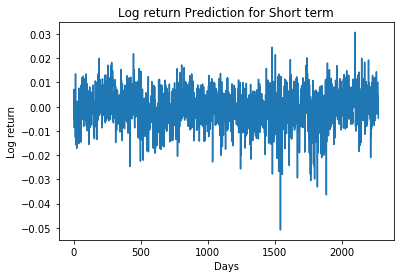

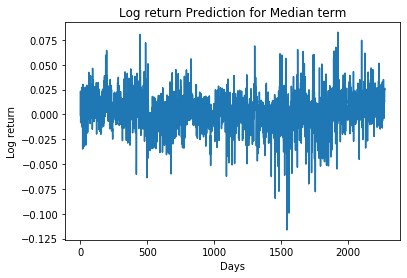

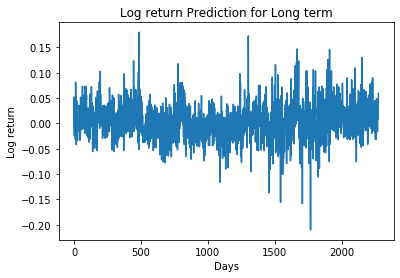

In [101]:
plt.plot(y_pred1)
plt.title('Log return Prediction for Short term')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y_pred2)
plt.title('Log return Prediction for Median term')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y_pred3)
plt.title('Log return Prediction for Long term')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()

<Figure size 1440x576 with 0 Axes>

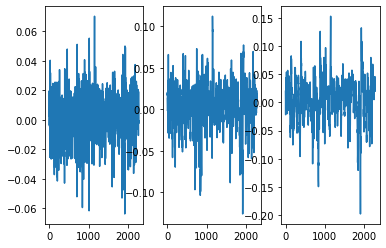

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))

y = [y1_test,y2_test,y3_test]

fig, ax = plt.subplots(nrows=1, ncols=3)
i = 0
for row in ax:
        row.plot(y[i])
        i = i+1

plt.show()

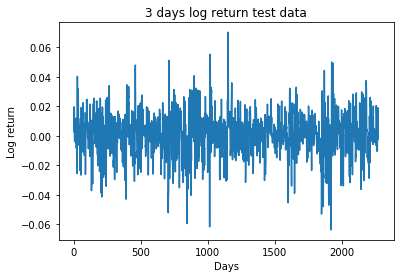

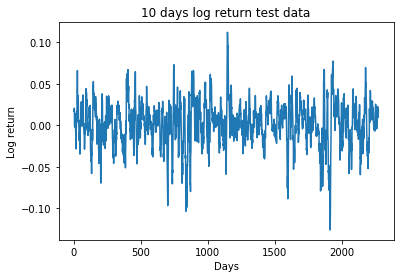

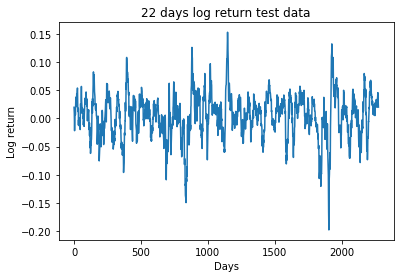

In [103]:
# Compared with real data
plt.plot(y1_test)
plt.title('3 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y2_test)
plt.title('10 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y3_test)
plt.title('22 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()

In [104]:
def Result_Analysis(y_real,y_predict):
    bias = np.mean(y_real-y_predict)
    MAE = np.mean(np.abs(y_real-y_predict))
    RMSE = np.sqrt(np.mean((y_real-y_predict)**2))
    y_bar = np.mean(y_real)
    SST = np.sum((y_real- y_bar)**2)
    SSReg = np.sum((y_predict - y_bar)**2)
    R_squared = SSReg/SST
    
    return bias, MAE, RMSE, R_squared

display('bias, MAE, RMSE, R_squared',Result_Analysis(y1_test,y_pred1))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y2_test,y_pred2))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y3_test,y_pred3))

'bias, MAE, RMSE, R_squared'

(0.00098693752457597,
 0.012290847673429783,
 0.015999726395291385,
 0.25911931773685304)

'bias, MAE, RMSE, R_squared'

(-4.060427969154719e-05,
 0.024812880291828137,
 0.03234474885507976,
 0.48698654587940365)

'bias, MAE, RMSE, R_squared'

(-0.0007331956656415891,
 0.0393287045146107,
 0.05143314850183022,
 0.7376410080680845)

In [109]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

regr_ = DecisionTreeRegressor(max_depth=10)
Model_DecisionTreeRegressor_Short_Term = regr_.fit(X_train, y1_train)
Model_DecisionTreeRegressor_Med_Term = regr_.fit(X_train, y2_train)
Model_DecisionTreeRegressor_Long_Term = regr_.fit(X_train, y3_train)



y_pred_1 = Model_DecisionTreeRegressor_Short_Term.predict(X_test) 
y_pred_2 = Model_DecisionTreeRegressor_Med_Term.predict(X_test)
y_pred_3 = Model_DecisionTreeRegressor_Med_Term.predict(X_test)

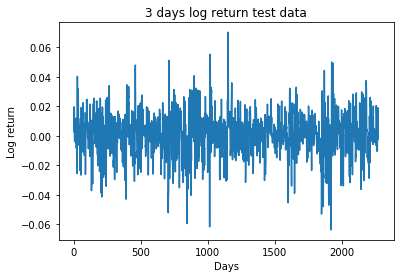

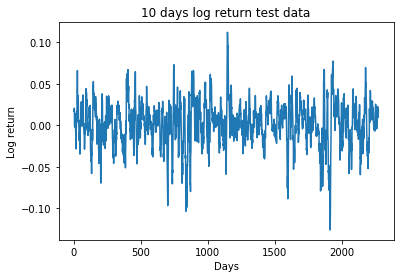

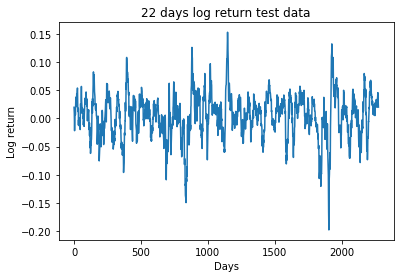

In [110]:
# Compared with real data
plt.plot(y1_test)
plt.title('3 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y2_test)
plt.title('10 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y3_test)
plt.title('22 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()

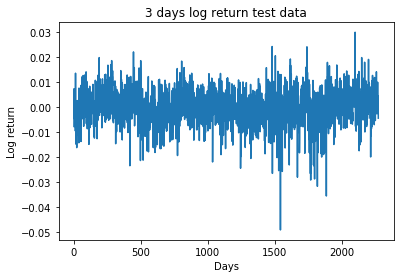

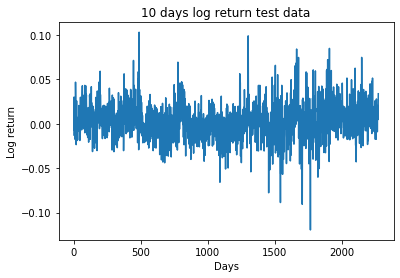

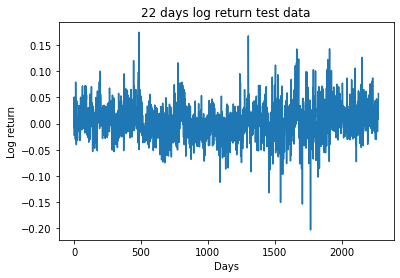

In [112]:
y_pred_1 = 0.7*y_pred1+0.3*y_pred_1
y_pred_2 = 0.3*y_pred3+0.3*y_pred_2
y_pred_3 = 0.7*y_pred3+0.3*y_pred_3

# Compared with real data
plt.plot(y_pred_1)
plt.title('3 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y_pred_2)
plt.title('10 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()
plt.plot(y_pred_3)
plt.title('22 days log return test data')
plt.xlabel('Days')
plt.ylabel('Log return')
plt.show()

In [113]:
display('bias, MAE, RMSE, R_squared',Result_Analysis(y1_test,y_pred_1))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y2_test,y_pred_2))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y3_test,y_pred_3))

'bias, MAE, RMSE, R_squared'

(0.0007383585994129065,
 0.012201062905583844,
 0.015897539515635408,
 0.24426675393817726)

'bias, MAE, RMSE, R_squared'

(-0.0011744877141653676,
 0.025192061756435832,
 0.03289520047234326,
 0.5119169692265989)

'bias, MAE, RMSE, R_squared'

(-0.0008184517976894756,
 0.03886891678991876,
 0.0508358942716722,
 0.6969560620091328)